# AI Kepler - demo

## Packages import

In [1]:
# conda env
try:
    get_ipython().system('echo $CONDA_PREFIX')
except:
    pass

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
# External packages
import torch
import numpy as np
import pandas as pd
import time
import os
# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [3]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [4]:
torch.cuda.is_available()

False

### Pareto front

In [5]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 32,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    # Fig params
    plt.rc('text', usetex=True)
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)
        
    return fig

## Benchmark config

### Benchmark config

In [6]:
benchmark_name = "benchmark-mechanical_energy"

Test cases loading

In [7]:
import benchmark_cases_relativistic_energy as bench_cases

Results path

In [8]:
try:
    os.mkdir(benchmark_name)
except:
    print("Folder already exists")
os.chdir("./%s/"%(benchmark_name))

Folder already exists


Config

In [9]:
EPOCH_REFRESH_RATE = 100
N_ATTEMPTS = 5

### Loading hyperparams

In [10]:
from my_run_config_physics import *

## Sanity checks and setup

In [11]:
TEST_CASES_SYMBOLIC_TARGETS = {}

---------------------------------------------------------------------------------
-------------------------------------- mechanical_energy ---------------------------------------
---------------------------------------------------------------------------------
Data


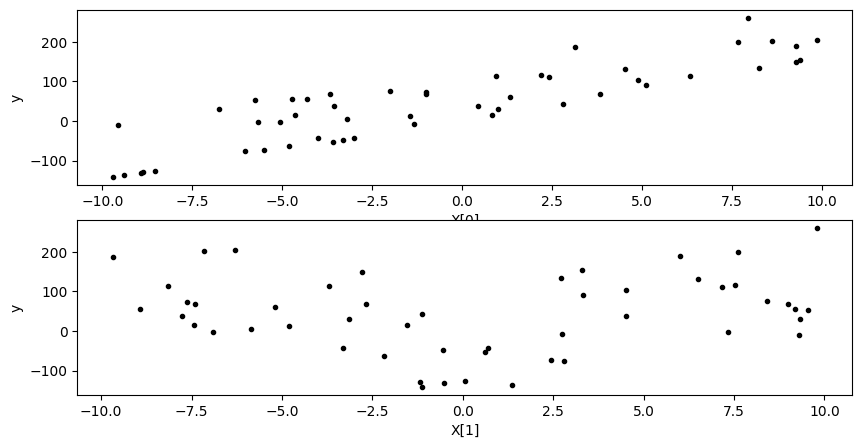

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'exp': 7, 'log': 8, 'sin': 9, 'cos': 10, '1': 11, 'g': 12, 'm': 13, 'z': 14, 'v': 15}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt exp log sin cos 1 g m z v E dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 6, scale = 5)
- NoUselessInversePrior (['inv', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- NestedTrigonometryPrior (tokens = ['sin' 'cos'], nesting forbidden)
- OccurrencesPrior (tokens ['1'] can be used [3] times max)
-------------------------- Dataset -------------------------
X        : torch.Size([2, 50]) 
y_target : torch.Size([50])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' .

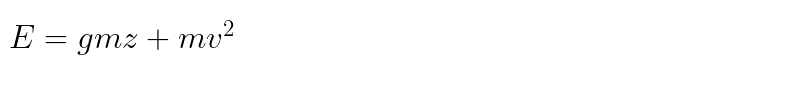

Simplified expression:


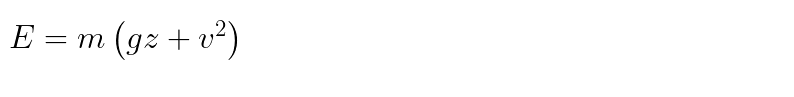

free const opti time = 3.688334 ms


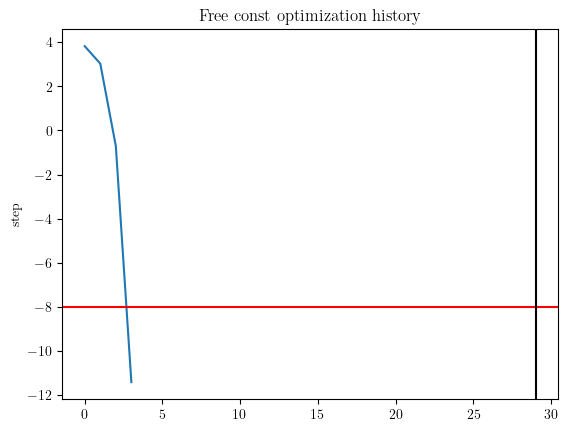

Ideal reward : 0.9999999800311574


In [12]:
for test_case in bench_cases.TEST_CASES:
    
    # Loading test case
    test_case_dict = test_case(DEVICE)
    X    = test_case_dict["X"]
    y    = test_case_dict["y"]
    name = test_case_dict["name"]
    library_config        = test_case_dict["library_config"]
    target_program_str    = test_case_dict["target_program_str"]
    expected_ideal_reward = test_case_dict["expected_ideal_reward"]
    candidate_wrapper     = test_case_dict["candidate_wrapper"]
    
    print("---------------------------------------------------------------------------------")
    print("-------------------------------------- %s ---------------------------------------"%(name))
    print("---------------------------------------------------------------------------------")

    # Making run config
    run_logger     = monitoring.RunLogger()
    run_visualiser = monitoring.RunVisualiser(epoch_refresh_rate=EPOCH_REFRESH_RATE)
    run_config = {
        "learning_config"      : learning_config,
        "reward_config"        : reward_config,
        "free_const_opti_args" : free_const_opti_args,
        "library_config"       : library_config,
        "priors_config"        : priors_config,
        "cell_config"          : cell_config,
        "run_logger"           : run_logger,
        "run_visualiser"       : run_visualiser,
    }
    
    # Sanity check 
    target_program = physo.task.benchmark.sanity_check (X, y, run_config, 
                                                       target_program_str    = target_program_str, 
                                                       expected_ideal_reward = expected_ideal_reward, 
                                                       candidate_wrapper     = candidate_wrapper)
    
    # Target symbolic
    TEST_CASES_SYMBOLIC_TARGETS.update({name:target_program})
    

## Runs

In [13]:
# Initialize all cases results
cases_names = [*TEST_CASES_SYMBOLIC_TARGETS.keys()]
results_all_cases = pd.DataFrame(
    index   = cases_names,
    columns = ["name", "mean_reward", "symbolic_recovery_rate", "reward_recovery_rate", "mean_epochs", "mean_time"],
    )
results_all_cases["name"] = cases_names

# Test case loop
for test_case in bench_cases.TEST_CASES:
    
    test_case_dict = test_case(DEVICE)
    name = test_case_dict["name"]
    print("\n----- Test Case : %s -----"%(name))
    
    # Making a result log for this test case
    results = pd.DataFrame(
        index   = np.arange(0, N_ATTEMPTS),
        columns = ["name", "i_attempt", "reward", "symbolic_recovery", "reward_recovery", "epochs", "time"],
        )
    
    for i_attempt in range(N_ATTEMPTS):
        print("\n -> Recovery attempt %i/%i"%(i_attempt+1, N_ATTEMPTS))

        # Loading test case
        test_case_dict = test_case(DEVICE)
        X    = test_case_dict["X"]
        y    = test_case_dict["y"]
        name = test_case_dict["name"]
        library_config        = test_case_dict["library_config"]
        target_program_str    = test_case_dict["target_program_str"]
        expected_ideal_reward = test_case_dict["expected_ideal_reward"]
        candidate_wrapper     = test_case_dict["candidate_wrapper"]

        # Results of all attempts
        save_path_results         = "%s.csv"           %(name)
        # Results per attempt
        save_path_log             = "%s_%s.log"        %(name, i_attempt)
        save_path_training_curves = "%s_%s_curves.png" %(name, i_attempt)
        save_path_pareto          = "%s_%s_pareto.png" %(name, i_attempt)
        
        # Making run config
        run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                              do_save = True)
        
        run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = EPOCH_REFRESH_RATE,
                                                   save_path = save_path_training_curves,
                                                   do_show   = False,
                                                   do_prints = False,
                                                   do_save   = True, )

        run_config = {
            "learning_config"      : learning_config,
            "reward_config"        : reward_config,
            "free_const_opti_args" : free_const_opti_args,
            "library_config"       : library_config,
            "priors_config"        : priors_config,
            "cell_config"          : cell_config,
            "run_logger"           : run_logger,
            "run_visualiser"       : run_visualiser,
        }

        # Run
        t000 = time.perf_counter()
        rewards, candidates = physo.fit(X, y, run_config, stop_reward = expected_ideal_reward, candidate_wrapper = candidate_wrapper)
        t111 = time.perf_counter()
        run_time = t111-t000

        # Recovery status
        try:
            symbolic_recovery = sympy.simplify(candidates[-1].get_infix_sympy(do_simplify=True) - TEST_CASES_SYMBOLIC_TARGETS[name].get_infix_sympy(do_simplify=True)) == 0
        except:
            symbolic_recovery = False
            print("Sympy failed to simplify")
        eps = 1e-5
        reward_recovery   = (expected_ideal_reward - rewards[-1]) <= 2*eps

        # Save final curves
        run_visualiser.save_visualisation()
        run_visualiser.save_data()
        
        # Prints
        print("    -> Overall best  at R=%f"%(run_logger.overall_max_R_history[-1]))
        print("    -> Raw expression        : \n%s"%(run_logger.best_prog.get_infix_pretty(do_simplify=False, )))
        print("    -> Symbolic recovery = %s"%(symbolic_recovery))
        print("    -> Reward recovery   = %s"%(reward_recovery))
        print("  -> Time = %f s"%(run_time))
        
        # Logging results
        results["name"              ].iloc[i_attempt] = name
        results["i_attempt"         ].iloc[i_attempt] = i_attempt
        results["reward"            ].iloc[i_attempt] = rewards[-1]
        results["symbolic_recovery" ].iloc[i_attempt] = symbolic_recovery
        results["reward_recovery"   ].iloc[i_attempt] = reward_recovery
        results["epochs"            ].iloc[i_attempt] = run_logger.epoch
        results["time"              ].iloc[i_attempt] = run_time
        # Saving updated csv
        results.to_csv(save_path_results)

        # Save Pareto front
        try:
            fig = plot_pareto_front(run_logger, eq_text_size=20)
            fig.savefig(save_path_pareto)
        except:
            print("Pareto front plot failed.") # can fail because of sympy
        
        # Closing figs
        plt.close('all')
    
    # Logging overall test case results
    results_all_cases ["mean_reward"            ].loc[name] = results     ["reward"           ].to_numpy().mean()
    results_all_cases ["symbolic_recovery_rate" ].loc[name] = 100*results ["symbolic_recovery"].to_numpy().astype(int).sum()/N_ATTEMPTS
    results_all_cases ["reward_recovery_rate"   ].loc[name] = 100*results ["reward_recovery"  ].to_numpy().astype(int).sum()/N_ATTEMPTS
    results_all_cases ["mean_epochs"            ].loc[name] = results     ["epochs"           ].to_numpy().mean()
    results_all_cases ["mean_time"              ].loc[name] = results     ["time"             ].to_numpy().mean()
    # Save
    results_all_cases.to_csv("_results.csv")
    


----- Test Case : mechanical_energy -----

 -> Recovery attempt 1/5
Sympy failed to simplify
    -> Overall best  at R=1.000000
    -> Raw expression        : 
                 ⎛   ⎛        0.5⎞       ⎞
  ⎛        2⎞    ⎜   ⎜     ⎛1⎞   ⎟    0.5⎟
m⋅⎝-g⋅z + v ⎠⋅sin⎜log⎜-1 + ⎜─⎟   ⎟ + 1   ⎟
                 ⎝   ⎝     ⎝1⎠   ⎠       ⎠
    -> Symbolic recovery = False
    -> Reward recovery   = True
  -> Time = 13.202198 s
Pareto front plot failed.

 -> Recovery attempt 2/5
Sympy failed to simplify
    -> Overall best  at R=1.000000
    -> Raw expression        : 
                          2  
-g⋅m⋅z + 1⋅1⋅log(cos(1))⋅v ⋅m
    -> Symbolic recovery = False
    -> Reward recovery   = True
  -> Time = 20.053897 s

 -> Recovery attempt 3/5
Sympy failed to simplify
    -> Overall best  at R=1.000000
    -> Raw expression        : 
  ⎛             2⎞
  ⎜      m⋅(v⋅1) ⎟
g⋅⎜m⋅z + ────────⎟
  ⎝         g    ⎠
    -> Symbolic recovery = False
    -> Reward recovery   = True
  -> Time = 13.587206 s

 

## Results summary

In [14]:
# Show
results_all_cases

,name,mean_reward,symbolic_recovery_rate,reward_recovery_rate,mean_epochs,mean_time
mechanical_energy,mechanical_energy,1.0,0.0,100.0,6.6,15.000996
